In [80]:
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification, pipeline
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
from glob import glob
import pandas as pd

In [3]:
path = "../NER_output/STRAIN"

# Load your fine-tuned model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(path, model_max_length=512)
# model = AutoModel.from_pretrained(path)
model = AutoModelForTokenClassification.from_pretrained(path)

In [5]:
with open("../NER/STRAIN/train.jsonls") as f:
    data = json.load(f)
sentences = []
for s in data:
    sen = s["data"]["text"]
    sentences.append(sen)

In [7]:
# Prepare to extract embeddings
model.eval()  # Set model to evaluation mode
embeddings = []

# Process the dataset and extract embeddings
with torch.no_grad():
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", padding=True)
        outputs = model(**inputs)

        # Extract embeddings from the desired layer (here, the last hidden state)
        embeddings.append(outputs) # .mean(dim=1)

In [8]:
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[-1.2484,  0.0321,  0.7644],
         [-2.8934, -2.9973,  6.7355],
         [-2.6740, -3.1271,  6.6292],
         [-2.8475, -2.8636,  6.7307],
         [-2.7086, -2.8604,  6.6305],
         [-2.7693, -2.9314,  6.6877],
         [-2.8925, -3.0910,  6.5892],
         [-2.7277, -3.0633,  6.7816],
         [-2.9291, -3.0768,  6.5809],
         [-2.7438, -3.1691,  6.3385],
         [-2.0711, -3.1157,  5.5512],
         [-0.8274, -3.1098,  4.4368],
         [-2.2652, -2.0905,  4.9176],
         [-2.9182, -2.5314,  5.7975],
         [-2.8526, -3.0459,  6.2158],
         [ 3.6862, -2.1391, -1.6871],
         [ 0.9072,  1.2415, -2.2936],
         [-0.9447,  2.6673, -1.9947],
         [-2.1829,  3.1207, -1.6605],
         [-3.3952,  3.5701, -1.3232],
         [-3.0621,  3.2464, -1.3595],
         [-2.8995,  2.8594, -1.0859],
         [-1.7275,  2.7175, -2.4621],
         [-1.8237,  2.4665, -1.0927],
         [-2.8991, -2.7252,  6.0733],
         [

In [6]:
# Prepare to extract embeddings
model.eval()  # Set model to evaluation mode
embeddings = []

# Process the dataset and extract embeddings
with torch.no_grad():
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", padding=True)
        outputs = model(**inputs)

        # Extract embeddings from the desired layer (here, the last hidden state)
        embeddings.append(outputs.last_hidden_state[0].numpy()) # .mean(dim=1)

AttributeError: 'TokenClassifierOutput' object has no attribute 'last_hidden_state'

In [26]:
embeddings[0]

array([0.00298297, 0.00169892, 0.00122533, 0.00087838, 0.00259231,
       0.00142043, 0.00113357, 0.00017687, 0.00326663, 0.00478377,
       0.00260906, 0.00344554, 0.00335993, 0.00134489, 0.00202611,
       0.00194936, 0.0009747 , 0.00167482, 0.00135064, 0.00252073,
       0.00191681, 0.00128709, 0.00133486, 0.00223988, 0.00201248,
       0.00188014, 0.00293685, 0.00242801, 0.00274609, 0.00176967,
       0.00374129, 0.00136241, 0.00278141, 0.00178589, 0.00174554,
       0.00192649, 0.00173931, 0.00190859, 0.00290626, 0.00277397,
       0.00124775, 0.0020343 , 0.00312996, 0.00690725, 0.00158671,
       0.00297416, 0.00091441, 0.00146324, 0.00235129, 0.00298297],
      dtype=float32)

In [25]:
fit = umap.UMAP()
u = fit.fit_transform(embeddings[0])

ValueError: Expected 2D array, got 1D array instead:
array=[0.00298297 0.00169892 0.00122533 0.00087838 0.00259231 0.00142043
 0.00113357 0.00017687 0.00326663 0.00478377 0.00260906 0.00344554
 0.00335993 0.00134489 0.00202611 0.00194936 0.0009747  0.00167482
 0.00135064 0.00252073 0.00191681 0.00128709 0.00133486 0.00223988
 0.00201248 0.00188014 0.00293685 0.00242801 0.00274609 0.00176967
 0.00374129 0.00136241 0.00278141 0.00178589 0.00174554 0.00192649
 0.00173931 0.00190859 0.00290626 0.00277397 0.00124775 0.0020343
 0.00312996 0.00690725 0.00158671 0.00297416 0.00091441 0.00146324
 0.00235129 0.00298297].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Do it instead with the feature extraction method 

In [10]:
ner = "STRAIN"

In [14]:
path= f"../NER_output/{ner}"

tokenizer = AutoTokenizer.from_pretrained(path, model_max_length=512)
model = AutoModelForTokenClassification.from_pretrained(path)

fe = pipeline(task='feature-extraction', model=model, tokenizer=tokenizer,
               aggregation_strategy="average", device=1)


In [33]:
features = []
for sentence in sentences:
    features.append(fe(sentence)[0])


In [61]:
flat = [np.array(i).flatten() for i in features]

In [67]:
def pad_arrays(arrays):
  """Pads all arrays in a list to the same length with 0s.
  """  
  max_len = max(len(arr) for arr in arrays)
  padded_arrays = [np.pad(arr, (0, max_len - len(arr)), mode='constant', constant_values=0) for arr in arrays]
  return padded_arrays


In [69]:
flat_pad = pad_arrays(flat)

In [70]:
fit = umap.UMAP()
u = fit.fit_transform(flat_pad)

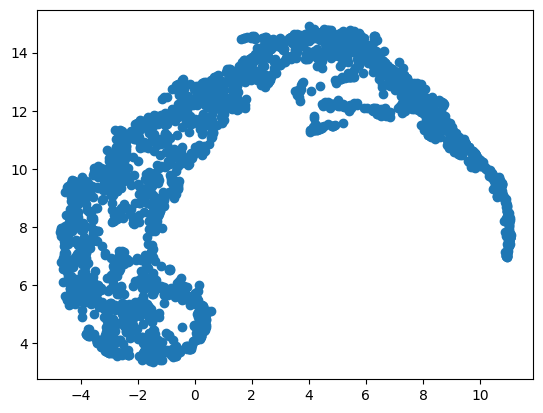

In [71]:
plt.scatter(u[:,0],u[:,1])

In [74]:
ners =["COMPOUND", "DISEASE", "EFFECT","ISOLATE","MEDIUM","METABOLITE","ORGANISM",
            "PHENOTYPE","PROTEIN","SPECIES","STRAIN"]

In [145]:
def pad_sequences(arrays):
  """Pads a list of numpy arrays to the same shape.

  Args:
    arrays: A list of NumPy arrays. All arrays must have the same
      dimensionality (rank).

  Returns:
    A list of padded NumPy arrays. The arrays will all have the same
    shape as the array with the largest shape in the original list.
  """
  max_len = np.max([arr.shape[0] for arr in arrays])
  padded_arrays = []
  for arr in arrays:
    padding_len = max_len - arr.shape[0]
    padded_array = np.pad(arr, ((padding_len, 0), (0, 0)), mode='constant')
    padded_arrays.append(padded_array)
  return padded_arrays

In [156]:
l = []
for ner in ners:
    with open(f"../NER/{ner}/train.jsonls") as f:
        data = json.load(f)
    sentences = []
    for s in data:
        sen = s["data"]["text"]
        sentences.append(sen)
    path= f"../NER_output/{ner}"
    
    tokenizer = AutoTokenizer.from_pretrained(path, model_max_length=512)
    model = AutoModelForTokenClassification.from_pretrained(path)
    
    fe = pipeline(task='feature-extraction', model=model, tokenizer=tokenizer,
                   aggregation_strategy="average", device=1)
    features = []
    for sentence in sentences:
        emb = fe(sentence)[0]
        features.append(np.array(emb))
    
    flat = [np.array(i).flatten() for i in features]
    flat_pad = pad_arrays(flat)
    
    fit = umap.UMAP()
    u = fit.fit_transform(flat_pad)
    df = pd.DataFrame(u,columns=["x","y"])
    df["ner"] = ner
    l.append(df)

/home/tu/tu_tu/tu_bbpgo01/miniconda3/envs/l/lib/python3.12/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/home/tu/tu_tu/tu_bbpgo01/miniconda3/envs/l/lib/python3.12/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/home/tu/tu_tu/tu_bbpgo01/miniconda3/envs/l/lib/python3.12/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/home/tu/tu_tu/tu_bbpgo01/miniconda3/envs/l/lib/python3.12/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/hom

In [157]:
dfs = pd.concat(l)

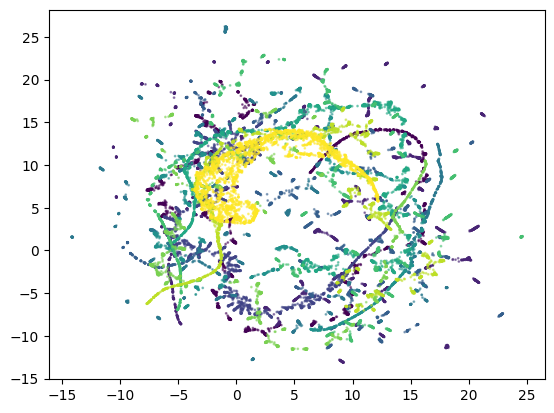

In [158]:
plt.scatter(x=dfs.x,y=dfs.y,c=dfs.ner.astype("category").cat.codes,s = 1,alpha=.5)